In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy import stats

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

SEED = 42
n_splits = 8
n_estimators=5000
early_stopping_rounds = 100

In [7]:
train_data = pd.read_csv('../data/raw/train.csv')  #index_col='id'
test_data = pd.read_csv('../data/raw/test.csv') # , index_col='id'
data = pd.read_csv('../data/raw/podcast_dataset.csv')

print("train_data shape :",train_data.shape)
print("test_data shape :",test_data.shape)
print("data shape :",data.shape)

train_data shape : (750000, 12)
test_data shape : (250000, 11)
data shape : (52500, 11)


In [8]:
TARGET = 'Listening_Time_minutes'
data_clean = data.dropna(subset=[TARGET]).drop_duplicates()
print("data shape after dropping na and duplicates :",data.shape)

data shape after dropping na and duplicates : (52500, 11)


In [9]:
X= data_clean.drop(columns=[TARGET])
y= data_clean[TARGET]
train, test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train shape: {train.shape}")
print(f"Test  shape: {test.shape}")
print(f"Orig_clean  shape: {data_clean.shape}")

Train shape: (35894, 10)
Test  shape: (8974, 10)
Orig_clean  shape: (44868, 11)


In [14]:
vectorizer = TfidfVectorizer()
tfidf_train = vectorizer.fit_transform(train_data['Podcast_Name'])
feature_names = vectorizer.get_feature_names_out()
tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=feature_names)
tfidf_test = vectorizer.transform(test_data['Podcast_Name'])
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=feature_names)

In [15]:
genre_mapping = {
    'Music': 0,         # 46.58 min (más escuchado)
    'True Crime': 1,    # 46.04 min
    'Health': 2,        # 45.74 min
    'Education': 3,     # 45.74 min
    'Technology': 4,    # 45.63 min
    'Business': 5,      # 45.54 min
    'Lifestyle': 6,     # 45.52 min
    'Sports': 7,        # 44.94 min
    'Comedy': 8,        # 44.43 min
    'News': 9           # 44.41 min (menos escuchado)
}

# Mapeo para Publication_Day basado en tiempo promedio de escucha
day_mapping = {
    'Tuesday': 0,     # 46.13 min (más escuchado)
    'Monday': 1,      # 45.97 min
    'Wednesday': 2,   # 45.81 min
    'Saturday': 3,    # 45.33 min
    'Friday': 4,      # 45.21 min
    'Thursday': 5,    # 44.87 min
    'Sunday': 6       # 44.82 min (menos escuchado)
}

# Mapeo para Publication_Time basado en tiempo promedio de escucha
time_mapping = {
    'Night': 0,      # 46.46 min (más escuchado)
    'Afternoon': 1,  # 45.53 min
    'Morning': 2,    # 44.96 min
    'Evening': 3     # 44.76 min (menos escuchado)
}

In [16]:
def data_process(df):
    df['Episode_Title_num'] = df['Episode_Title'].astype(str).str.replace('Episode ', '').astype(int)
    df['Guest_Popularity_percentage'].fillna(df['Guest_Popularity_percentage'].median(), inplace=True)
    df['Episode_Length_minutes'].fillna(df['Episode_Length_minutes'].median(), inplace=True)
    df['Number_of_Ads'].fillna(df['Number_of_Ads'].median(), inplace=True)
    df['Guest_Popularity_percentage'] = df['Guest_Popularity_percentage'].clip(upper=3)
    df['Episode_Sentiment'] = df['Episode_Sentiment'].replace({'Neutral': 0, 'Positive': 1, 'Negative': -1})

    df['Ad_Density'] = df['Number_of_Ads'] / (df['Episode_Length_minutes'] + 1e-3)
    df['Popularity_Diff'] = df['Host_Popularity_percentage'] - df['Guest_Popularity_percentage']
    df['Popularity_Interaction'] = df['Host_Popularity_percentage'] * df['Guest_Popularity_percentage']
    df['Host_Popularity_squared'] = df['Host_Popularity_percentage'] ** 2
    df['Popularity_Average'] = (df['Host_Popularity_percentage'] + df['Guest_Popularity_percentage'])/2
    
    df['Genre_Num'] = df['Genre'].map(genre_mapping)
    df['Publication_Day_Num'] = df['Publication_Day'].map(day_mapping)
    df['Publication_Time_Num'] = df['Publication_Time'].map(time_mapping)

    return df

train_data=data_process(train_data)
test_data=data_process(test_data)

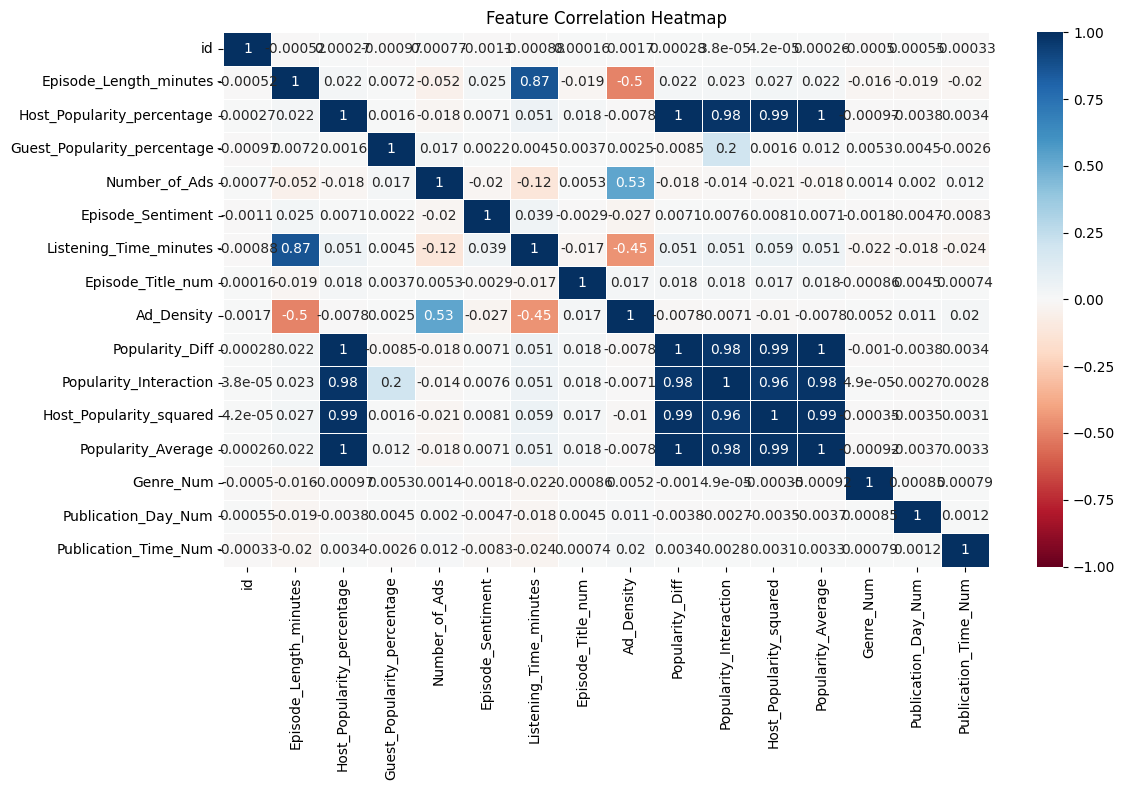

In [17]:
correlation_matrix=train_data[train_data.select_dtypes(include=['number']).columns.tolist()].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [18]:
cat_cols = train_data.select_dtypes(exclude=['number']).columns.tolist()
#train_data[cat_cols] = train_data[cat_cols].fillna(train_data[cat_cols].mode().iloc[0])
#test_data[cat_cols] = test_data[cat_cols].fillna(test_data[cat_cols].mode().iloc[0])
train_data[cat_cols] = train_data[cat_cols].fillna("Missing")
test_data[cat_cols] = test_data[cat_cols].fillna("Missing")
print(cat_cols)
for col in cat_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.transform(test_data[col]) 

['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time']


In [19]:
train_data = pd.concat([train_data, tfidf_train_df], axis=1)
test_data = pd.concat([test_data, tfidf_test_df], axis=1)

In [20]:
X = train_data.drop(['id','Listening_Time_minutes'],axis=1)
y = train_data['Listening_Time_minutes']
test = test_data.drop(['id'],axis=1)

print('true y min:',y.min())
print('true y max:',y.max())
print('true y mean:',y.mean())
print('true y median:',y.median())

true y min: 0.0
true y max: 119.97
true y mean: 45.43740628813335
true y median: 43.37946


LightGBM

In [25]:
kf = KFold(n_splits, shuffle=True, random_state=42)
kf_splits = kf.split(X)
scores1 = []
test_preds1 = []

lgbm_params1 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': n_estimators,
    'learning_rate': 0.08,
    'max_depth': 15,
    'num_leaves': 64, 
    'reg_alpha' : 1,
    'reg_lambda' : 8,
    'colsample_bytree' : 0.7,
    'subsample' : 1.0,
    'subsample_freq' : 6,
    'seed': SEED,
    'verbose': -1,
    'device' : 'cpu' 
}

for i, (train_idx, val_idx) in enumerate(kf_splits):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    callbacks = [lgb.early_stopping(stopping_rounds=early_stopping_rounds),lgb.log_evaluation(period=1000)]
    model = lgb.LGBMRegressor(**lgbm_params1)
    model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)],eval_metric='rmse', categorical_feature=cat_cols, callbacks=callbacks)
    
    val_pred = model.predict(X_val_fold, num_iteration=model.best_iteration_)
    score = mean_squared_error(y_val_fold, val_pred,squared=False)
    scores1.append(score)
    
    test_pred = np.maximum(model.predict(test, num_iteration=model.best_iteration_),0)
    test_preds1.append(test_pred)

    
    print(f'LightGBM Fold {i + 1} rmse: {score}')
print(f'LightGBM rmse: {np.mean(scores1):.5f};')


Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 12.8985
Early stopping, best iteration is:
[1768]	valid_0's rmse: 12.8722
LightGBM Fold 1 rmse: 12.872221726171372
Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 12.9104
[2000]	valid_0's rmse: 12.8824
Early stopping, best iteration is:
[2481]	valid_0's rmse: 12.8745
LightGBM Fold 2 rmse: 12.874520339144997
Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 12.9775
Early stopping, best iteration is:
[1881]	valid_0's rmse: 12.9586
LightGBM Fold 3 rmse: 12.958591419911663
Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 12.9512
[2000]	valid_0's rmse: 12.9209
Early stopping, best iteration is:
[2019]	valid_0's rmse: 12.9199
LightGBM Fold 4 rmse: 12.919876021739858
Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 12.9702
[2000]	valid_0's rmse: 12.933
Early stopping,

In [24]:
y_preds_lgb = np.mean(test_preds1, axis=0)
y_preds_lgb = y_preds_lgb
print('predict mean :',y_preds_lgb.mean())
print('predict median :',np.median(y_preds_lgb))
y_preds_lgb = np.clip(y_preds_lgb,0,119.97)
print('predict mean final:',y_preds_lgb.mean())
print('predict median final:',np.median(y_preds_lgb))

predict mean : nan
predict median : nan
predict mean final: nan
predict median final: nan


XGBoost

In [ ]:
kf = KFold(n_splits, shuffle=True, random_state=43)
kf_splits = kf.split(X)
scores1 = []
test_preds1 = []

xgb_params1 = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'n_estimators': n_estimators,
    'learning_rate': 0.08,
    'max_depth': 15,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.8,
    'reg_lambda': 4,
    'seed': SEED,
    'tree_method': 'hist',  # 使用 hist 方法加速训练
    'device': 'gpu'
}

for i, (train_idx, val_idx) in enumerate(kf_splits):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    model = xgb.XGBRegressor(**xgb_params1)
    model.fit(X_train_fold,
                y_train_fold,
                eval_set=[(X_val_fold, y_val_fold)],
                early_stopping_rounds=early_stopping_rounds, verbose=1000)

    val_pred = model.predict(X_val_fold)
    score = mean_squared_error(y_val_fold, val_pred, squared=False)
    scores1.append(score)

    test_pred = np.maximum(model.predict(test), 0)
    test_preds1.append(test_pred)

    print(f'XGBoost Fold {i + 1} rmse: {score}')
print(f'XGBoost rmse: {np.mean(scores1):.5f};')

TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
y_preds_xgb = np.mean(test_preds1, axis=0)
y_preds_xgb = y_preds_xgb
print('predict mean :',y_preds_xgb.mean())
print('predict median :',np.median(y_preds_xgb))
y_preds_xgb = np.clip(y_preds_xgb,0,119.97)
print('predict mean final:',y_preds_xgb.mean())
print('predict median final:',np.median(y_preds_xgb))

Random forest

In [ ]:
kf = KFold(n_splits, shuffle=True, random_state=45)
kf_splits = kf.split(X)
scores1 = []
test_preds1 = []

random_forest_params = {
    'n_estimators': 100,  # 树的数量
    'max_depth': 15,  # 树的最大深度
    'min_samples_split': 2,  # 内部节点再划分所需最小样本数
    'min_samples_leaf': 1,  # 叶节点最少样本数
    'max_features': 'auto',  # 寻找最佳分割时要考虑的特征数量
    'bootstrap': True,
    'random_state': SEED,
    'n_jobs': -1,  # 使用所有可用的处理器
}

for i, (train_idx, val_idx) in enumerate(kf_splits):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    model = RandomForestRegressor(**random_forest_params)
    model.fit(X_train_fold, y_train_fold)

    val_pred = model.predict(X_val_fold)
    score = mean_squared_error(y_val_fold, val_pred, squared=False)
    scores1.append(score)

    test_pred = np.maximum(model.predict(test), 0)
    test_preds1.append(test_pred)

    print(f'Random Forest Fold {i + 1} rmse: {score}')

print(f'Random Forest rmse: {np.mean(scores1):.5f};')

In [ ]:
y_preds_rf = np.mean(test_preds1, axis=0)
y_preds_rf = y_preds_rf
print('predict mean :',y_preds_rf.mean())
print('predict median :',np.median(y_preds_rf))
y_preds_rf = np.clip(y_preds_rf,0,119.97)
print('predict mean final:',y_preds_rf.mean())
print('predict median final:',np.median(y_preds_rf))

In [ ]:
y_preds = y_preds_lgb*0.2 + y_preds_xgb*0.7 + y_preds_rf*0.1
# Save predictions for submission
submission = pd.DataFrame({'id': test_data['id'], 'Listening_Time_minutes': y_preds})
submission.to_csv('submission.csv', index=False)
print(submission.head())